In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
model = 'random_direction'
method = 'mean'

df_eval = pd.concat([
    pd.read_csv(f'evaluate/evaluate_{model}_{i}.csv')
    for i in range(99, 100)
])

In [17]:
df_eval.columns

Index(['velocity', 'users', 'towers', 'sampling', 'district_size', 'accuracy',
       'accuracy_std', 'error', 'error_std', 'execution_time'],
      dtype='object')

In [19]:
len(df_eval)

96

In [20]:
# df_eval = getattr(df_eval.groupby(['towers', 'sampling', 'district_size']), method)().reset_index()
df_eval = getattr(df_eval.groupby(['velocity', 'towers', 'users']), method)().reset_index()

In [22]:
df_eval.head()

,velocity,towers,users,sampling,district_size,accuracy,accuracy_std,error,error_std,execution_time
0,"(0.01, 0.01)",16,16,1,1,0.525065,0.037435,19.547622,12.291499,0.719798
1,"(0.01, 0.01)",16,64,1,1,0.453369,0.011312,22.444424,10.937966,3.149260
2,"(0.01, 0.01)",16,144,1,1,0.443649,0.006510,22.767940,9.976453,16.531000
3,"(0.01, 0.01)",16,256,1,1,0.495789,0.000468,19.345656,8.624407,58.399900
4,"(0.01, 0.01)",16,400,1,1,0.485977,0.000508,19.531112,8.239490,156.842000


In [24]:
df_eval.accuracy.describe()

count    96.000000
mean      0.230648
std       0.221705
min       0.043774
25%       0.069062
50%       0.122310
75%       0.270854
max       0.924479
Name: accuracy, dtype: float64

In [26]:
df_eval.error = df_eval.apply(lambda row: row['error'] / (96 / row.get('sampling', 1)), axis=1)

In [27]:
# df_eval = df_eval[['towers', 'sampling', 'district_size', 'accuracy', 'error', 'execution_time']]

In [28]:
df_eval.to_csv(f'evaluate_{model}_summ_{method}.csv')

In [31]:
df_eval.head()

,velocity,towers,users,sampling,district_size,accuracy,accuracy_std,error,error_std,execution_time
0,"(0.01, 0.01)",16,16,1,1,0.525065,0.037435,0.203621,12.291499,0.719798
1,"(0.01, 0.01)",16,64,1,1,0.453369,0.011312,0.233796,10.937966,3.149260
2,"(0.01, 0.01)",16,144,1,1,0.443649,0.006510,0.237166,9.976453,16.531000
3,"(0.01, 0.01)",16,256,1,1,0.495789,0.000468,0.201517,8.624407,58.399900
4,"(0.01, 0.01)",16,400,1,1,0.485977,0.000508,0.203449,8.239490,156.842000


# Analysis for districts

In [20]:
towers = 576
df = df_eval[df_eval.towers == towers].sort_values(['sampling', 'district_size'], ascending=[False, True])

In [21]:
df['accuracy'].as_matrix().reshape((6, 4))

array([[0.17684823, 0.2553078 , 0.45302554, 0.73963759],
       [0.15146665, 0.25288448, 0.45233832, 0.76045736],
       [0.1305768 , 0.20283113, 0.35052038, 0.60853859],
       [0.09864468, 0.16166517, 0.29522027, 0.54184638],
       [0.07793511, 0.13378454, 0.24636728, 0.46952424],
       [0.06616211, 0.10908339, 0.1990526 , 0.39418934]])

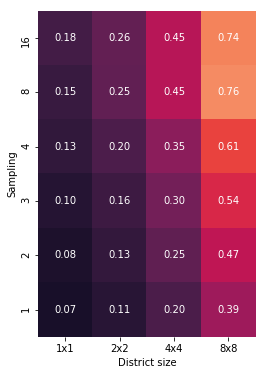

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.heatmap(
    df['accuracy'].as_matrix().reshape((6, 4)),
    ax=ax,
    xticklabels=df['district_size'].unique(),
    yticklabels=df['sampling'].unique(),
    vmax=1,
    vmin=0,
    square=True,
    fmt=".2f",
    annot=True,
    cbar=False,
)

xticklabels = df['district_size'].unique()
y_right_ticks = df['sampling'].unique()

ax.set(xlabel='District size', ylabel='Sampling')
ax.set_xticklabels(
    [f'{x}x{x}' for x in xticklabels],
    rotation=0
)

plt.savefig(f'./accuracy_districts_{towers}.png', dpi=300)

# Analysis for all metrics

In [32]:
def plot_heatmap(vel_restriction, metric='accuracy', ax=None, vmin=None, vmax=None, cbar=True, title='', cmap=None):
    df = df_eval[df_eval.velocity == vel_restriction]

    df = df.sort_values(['towers', 'users'], ascending=[False, True])
    
    n_tower_values = len(df.towers.unique())
    n_users_values = len(df.users.unique())
    
    if vel_restriction == '(0.1, 0.1)':
        y_right_ticks = reversed([0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2])
    elif vel_restriction == '(0.05, 0.05)':
        y_right_ticks = reversed([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])
    elif vel_restriction == '(0.01, 0.01)':
        y_right_ticks = reversed([0.04, 0.08, 0.12, 0.16, 0.19, 0.24, 0.28, 0.32])

    sns.heatmap(
        df[metric].as_matrix().reshape((n_tower_values, n_users_values)),
        ax=ax,
        xticklabels=df['users'].unique(),
        vmax=vmax,
        vmin=vmin,
        cbar=cbar,
        cmap=cmap,
        square=True,
        fmt=".2f",
        annot=True,
    )
    
    ax.set(xlabel='# Users', ylabel='Grid resolution / Relative velocity')
    ax.set_yticklabels(
        [
            f'{np.sqrt(t).astype(np.int)}x{np.sqrt(t).astype(np.int)} / {v}'
            for t, v in zip(df['towers'].unique(), y_right_ticks)
        ],
        rotation=0
    )
    
#     ax2 = ax.twin()
#     ax2.set_yticklabels(
#         y_right_ticks,
#         rotation=0
#     )
#     ax.set_title(title, pad=12)

# Accuracy and error analysis

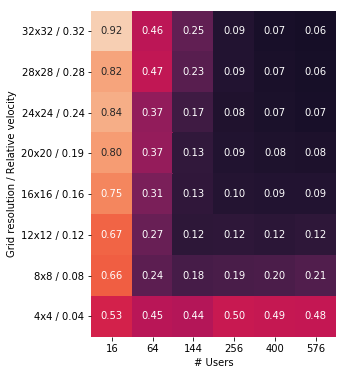

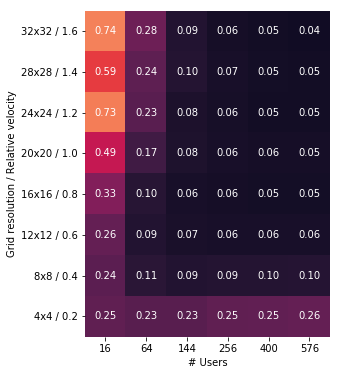

In [33]:
for i, vel in enumerate(df_eval.velocity.unique()):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    plot_heatmap(
        vel_restriction=vel,
        title=f'Velocity {vel}',
        metric='accuracy',
        ax=axes,
        vmin=0,
        vmax=1,
        cbar=False)

    plt.savefig(f'./accuracy_{model}_{vel}.png', dpi=300)

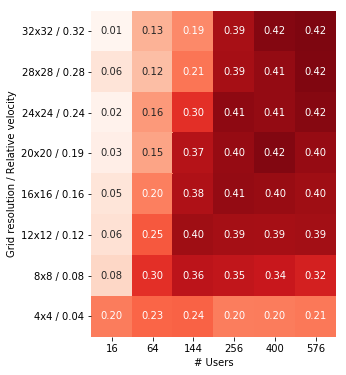

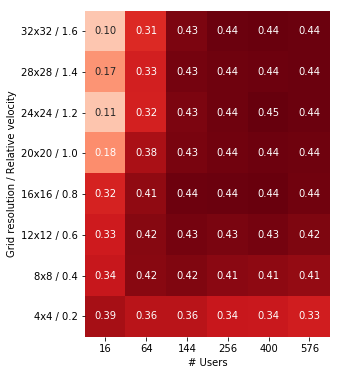

In [34]:
for i, vel in enumerate(df_eval.velocity.unique()):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    plot_heatmap(
        vel_restriction=vel,
        metric='error',
        ax=axes,
        title=f'Velocity {vel}',
        cbar=False,
        cmap='Reds',
        vmin=df_eval.error.min(),
        vmax=df_eval.error.max(),
    )

    plt.savefig(f'./error_{model}_{vel}.png', dpi=300)

# Execution time analysis

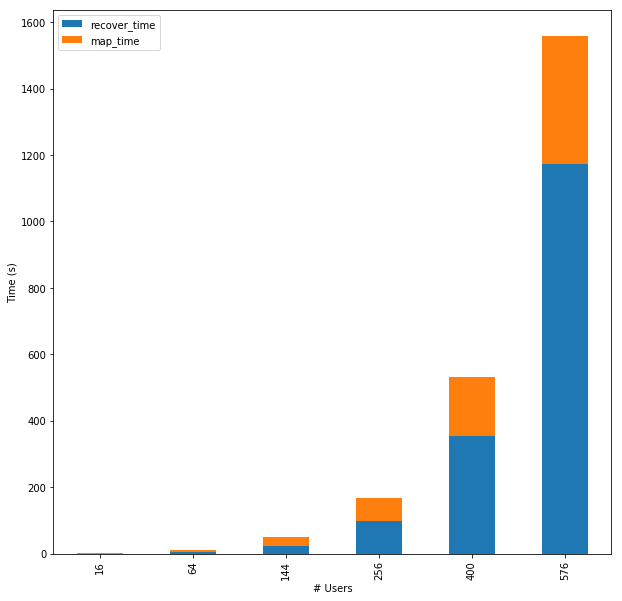

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

df_eval.groupby(['users']).mean()[[
        'recover_time',
        'map_time',
#         'execution_time',
]].plot.bar(ax=ax, stacked=True)

ax.set(xlabel="# Users", ylabel="Time (s)")
plt.savefig(f'./execution_time.png', dpi=300)

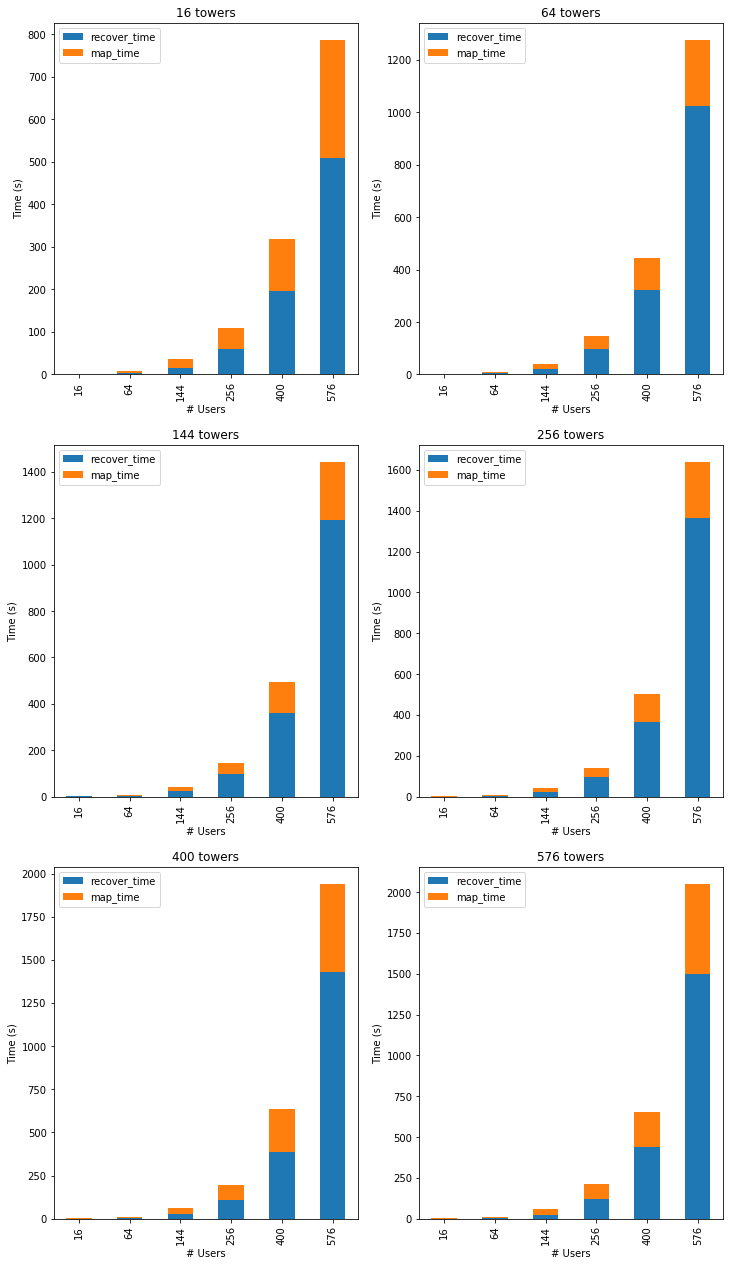

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 22))
axes = axes.flatten()

for ax, t in zip(axes, df_eval.towers.unique()):
    df_eval[df_eval.towers == t].groupby(['users']).mean()[[
        'recover_time',
        'map_time',
#         'execution_time',
    ]].plot.bar(ax=ax, stacked=True)
    ax.set_title(f'{t} towers')
    ax.set(xlabel='# Users', ylabel='Time (s)')

plt.savefig(f'./execution_time_by_towers.png', dpi=300)